In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Loading the Data

In [3]:
df = pd.read_csv("cleaned_demographics.csv").set_index("PID")
df.info()



<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, SAME10845F to SAME99866F
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GENDER             78 non-null     object 
 1   AGE                78 non-null     int64  
 2   HEIGHT             78 non-null     object 
 3   WEIGHT             78 non-null     object 
 4   HAND               78 non-null     object 
 5   LANGUAGE           78 non-null     object 
 6   LANGUAGE_2_TEXT    15 non-null     object 
 7   Unnamed: 8         78 non-null     object 
 8   ETHNICITY_15_TEXT  0 non-null      float64
 9   VIDEOGAMES         74 non-null     object 
 10  FPSGAMES           66 non-null     object 
 11  VRGAMES            45 non-null     object 
 12  VRSYSTEM           78 non-null     object 
 13  VRSYSTEM_2_TEXT    17 non-null     object 
dtypes: float64(1), int64(1), object(12)
memory usage: 9.1+ KB


In [4]:
df.head()

,GENDER,AGE,HEIGHT,WEIGHT,HAND,LANGUAGE,LANGUAGE_2_TEXT,Unnamed: 8,ETHNICITY_15_TEXT,VIDEOGAMES,FPSGAMES,VRGAMES,VRSYSTEM,VRSYSTEM_2_TEXT
PID,,,,,,,,,,,,,,
SAME10845F,Female,18,"5'8""",110,Right hand,English,NaN,White,NaN,Monthly,Monthly,NaN,No,NaN
SAME12079M,Male,22,"5'10""",155,Right hand,English,NaN,White,NaN,Weekly,Monthly,Yearly,No,NaN
SAME13296F,Female,19,"4'11""",107,Right hand,Other (please specify):,Spanish,"Hispanic, Latino, or Spanish",NaN,Monthly,Monthly,Yearly,No,NaN
SAME14450M,Male,25,"5'4""",135,Right hand,English,NaN,"East/Southeast Asian (e.g., Chinese, Korean, V...",NaN,Daily,Monthly,Weekly,Yes (please specify):,Meta Quest 2
SAME15874M,Male,19,"6'2""",185,Left hand,English,NaN,White,NaN,Weekly,Weekly,Monthly,Yes (please specify):,Meta Quest 2


- We can drop ETHNICITY_15_TEXT 
- HEIGHT and WEIGHT should be numeric
- Unnamed 8: is the target (1 category should be merged) and renamed
- Language 2 Text can be combined with Language

# Preprocessing

In [5]:
# No need to keep this column

df.drop(['ETHNICITY_15_TEXT'], axis=1 ,errors='ignore', inplace=True)


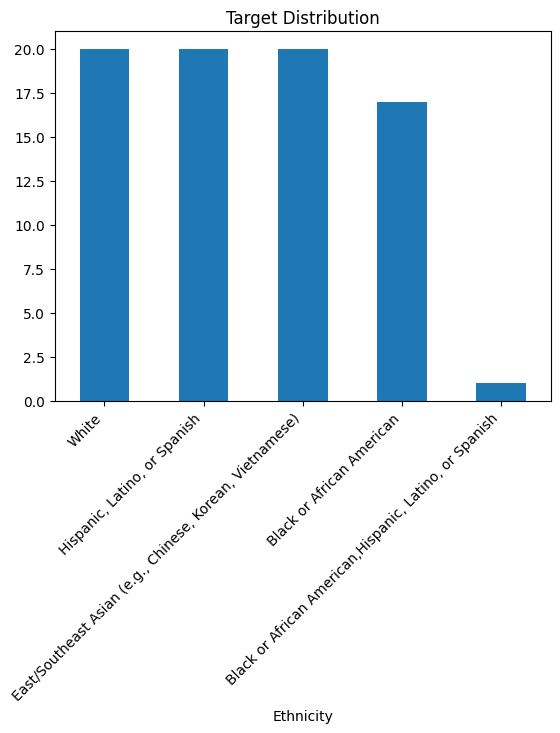

In [6]:
%matplotlib inline
plt.title("Target Distribution")
df["Unnamed: 8"].value_counts().plot(kind='bar')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Ethnicity")
plt.show()

Last category can be merged into the 3rd one

In [7]:
# Merge last category into the 3rd one

df_transformed = df.copy()
outlier = "Black or African American,Hispanic, Latino, or Spanish"
df_transformed.loc[df_transformed["Unnamed: 8"] == outlier, "Unnamed: 8"] = "Black or African American"
df_transformed.rename(columns={"Unnamed: 8": "ETHNICITY"}, inplace=True)
df_transformed["ETHNICITY"] = df_transformed["ETHNICITY"].str.replace(pat=r"\(.*\)", repl="", regex=True).str.strip()

df_transformed["ETHNICITY"].value_counts()

ETHNICITY
White                           20
Hispanic, Latino, or Spanish    20
East/Southeast Asian            20
Black or African American       18
Name: count, dtype: int64

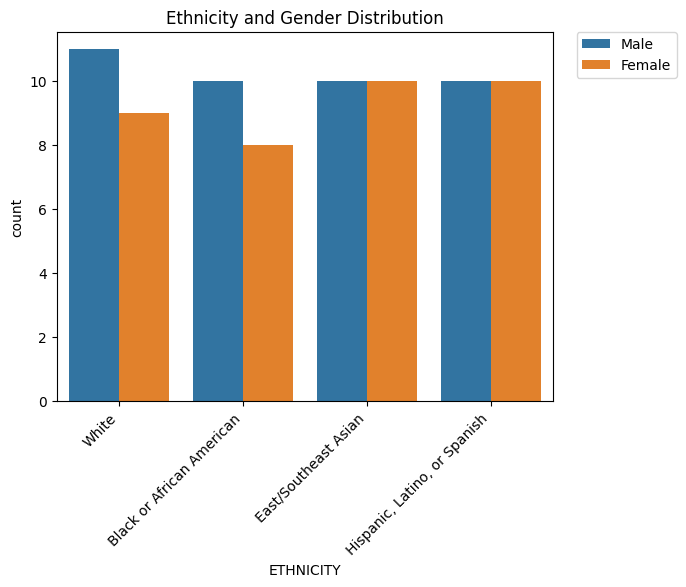

In [8]:

gender_ethnicity_counts = df_transformed[["ETHNICITY", "GENDER"]].value_counts().reset_index()
sns.barplot(gender_ethnicity_counts, x="ETHNICITY", y="count", hue="GENDER")
plt.xticks(rotation=45, ha='right')
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1), borderaxespad=0)
plt.title("Ethnicity and Gender Distribution")
plt.show()


In [9]:

# Convert Height and Weight to numeric values
df_converted = df_transformed.copy()
i = df_transformed.columns.get_indexer(["HEIGHT"]).item()


height, weight = df_converted.pop("HEIGHT"), df_converted.pop("WEIGHT")

inches = (height.replace(r"\"", "", regex=True)
                   .str.split("'")
                   .map(lambda x: 12 * int(x[0]) + int(x[1]))
            )
df_converted.insert(i, "HEIGHT_INCHES", inches)
df_converted.insert(i + 1, "WEIGHT_LBS", df["WEIGHT"].str.replace(r"\D", "", regex=True).astype(int))


df_converted.head()

,GENDER,AGE,HEIGHT_INCHES,WEIGHT_LBS,HAND,LANGUAGE,LANGUAGE_2_TEXT,ETHNICITY,VIDEOGAMES,FPSGAMES,VRGAMES,VRSYSTEM,VRSYSTEM_2_TEXT
PID,,,,,,,,,,,,,
SAME10845F,Female,18,68,110,Right hand,English,NaN,White,Monthly,Monthly,NaN,No,NaN
SAME12079M,Male,22,70,155,Right hand,English,NaN,White,Weekly,Monthly,Yearly,No,NaN
SAME13296F,Female,19,59,107,Right hand,Other (please specify):,Spanish,"Hispanic, Latino, or Spanish",Monthly,Monthly,Yearly,No,NaN
SAME14450M,Male,25,64,135,Right hand,English,NaN,East/Southeast Asian,Daily,Monthly,Weekly,Yes (please specify):,Meta Quest 2
SAME15874M,Male,19,74,185,Left hand,English,NaN,White,Weekly,Weekly,Monthly,Yes (please specify):,Meta Quest 2


# EDA and Fixing Nulls

The remaining nulls can be fixed in the following way:
  - `VIDEOGAMES`, `FPSGAMES`, `VRGAMES` are ordinal so if a value is none, we can assume they don't play (Encode as -1 or 0)?
  - `VRSYSTEM_2_TEXT` is too ambiguous so it should be dropped

In [10]:
df_lang_condensed = df_converted.copy()

df_lang_condensed["LANGUAGE_2_TEXT"] = df_converted["LANGUAGE_2_TEXT"].combine_first(df_converted["LANGUAGE"]).str.capitalize()
df_lang_condensed.drop("LANGUAGE", axis=1, inplace=True, errors='ignore')
df_lang_condensed.rename(columns={"LANGUAGE_2_TEXT": "LANGUAGE"}, inplace=True)

# Fix some languages
df_lang_condensed.loc["SAME54976F", "LANGUAGE"] = "English" # User more fluent in English
df_lang_condensed.loc["SAME35504M", "LANGUAGE"] = "Spanish" # User is hispanic, so assume Spanish?
df_lang_condensed["LANGUAGE"] = df_lang_condensed["LANGUAGE"].str.strip()


# User speaks Spanish but also knows French (Maybe condense to Spanish?)

# df_lang_condensed.loc["SAME41391M", "LANGUAGE"] = "Spanish"

Text(0.5, 1.0, 'Correlation Heatmap')

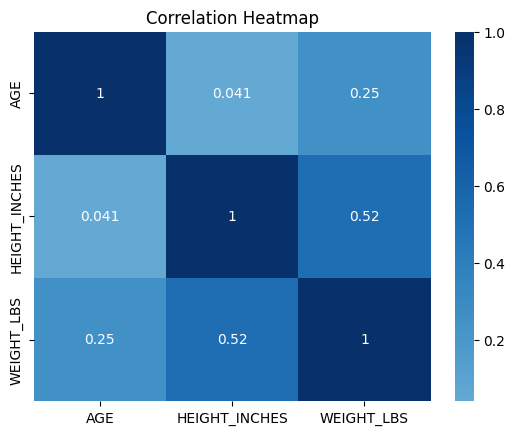

In [11]:
sns.heatmap(df_lang_condensed.corr(numeric_only=True), annot=True, cmap="Blues", center=0)
plt.title("Correlation Heatmap")

In [12]:
df_lang_condensed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, SAME10845F to SAME99866F
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   GENDER           78 non-null     object
 1   AGE              78 non-null     int64 
 2   HEIGHT_INCHES    78 non-null     int64 
 3   WEIGHT_LBS       78 non-null     int64 
 4   HAND             78 non-null     object
 5   LANGUAGE         78 non-null     object
 6   ETHNICITY        78 non-null     object
 7   VIDEOGAMES       74 non-null     object
 8   FPSGAMES         66 non-null     object
 9   VRGAMES          45 non-null     object
 10  VRSYSTEM         78 non-null     object
 11  VRSYSTEM_2_TEXT  17 non-null     object
dtypes: int64(3), object(9)
memory usage: 10.0+ KB


In [13]:
df_lang_condensed["LANGUAGE"].unique()

array(['English', 'Spanish', 'Burmese', 'French/spanish', 'Korean',
       'Cantonese', 'Vietnamese', 'Russian', 'Haitian creole'],
      dtype=object)

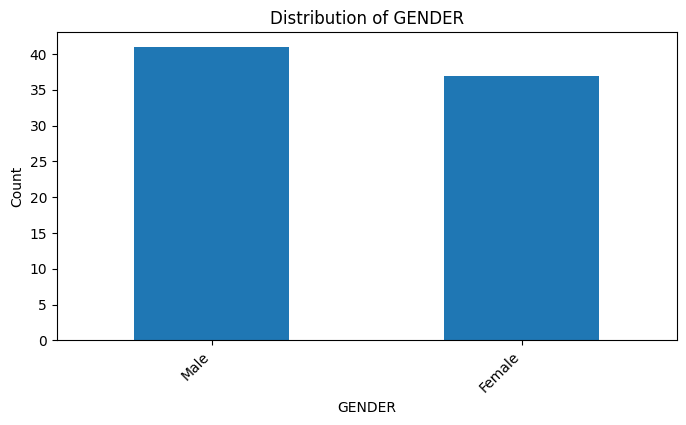

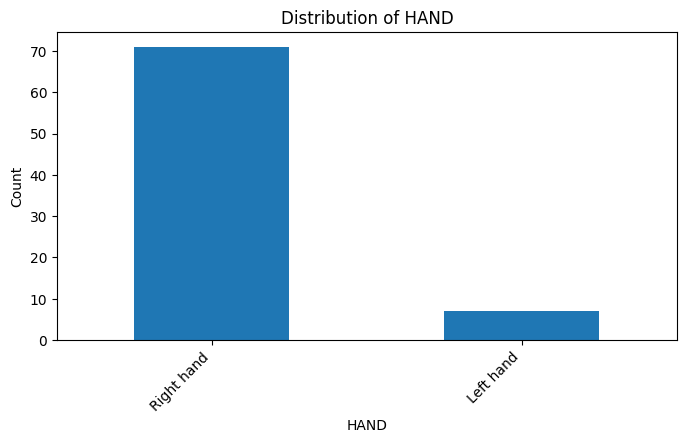

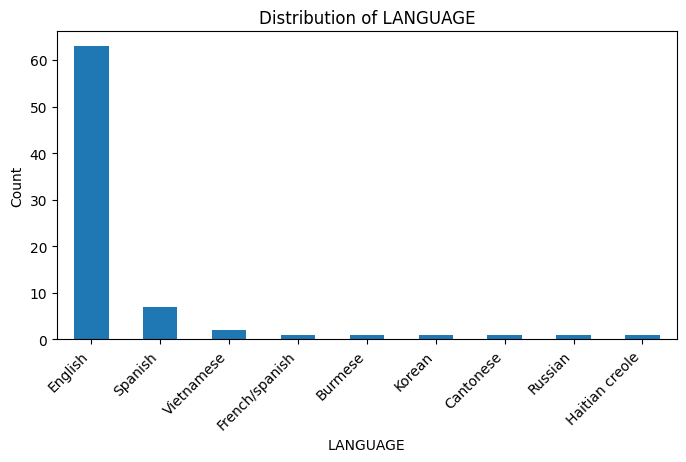

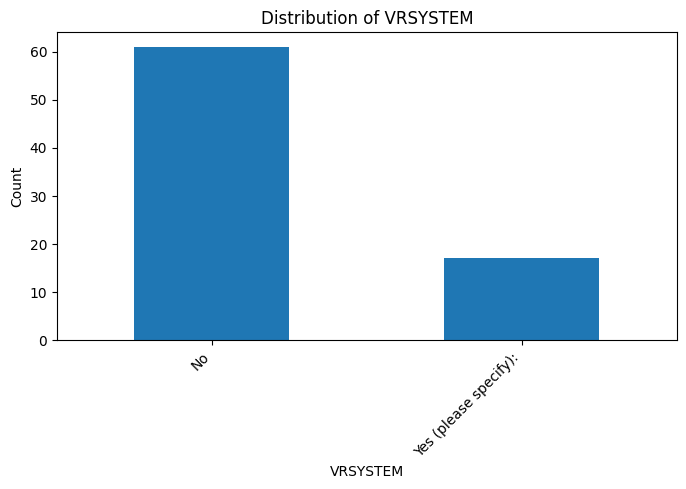

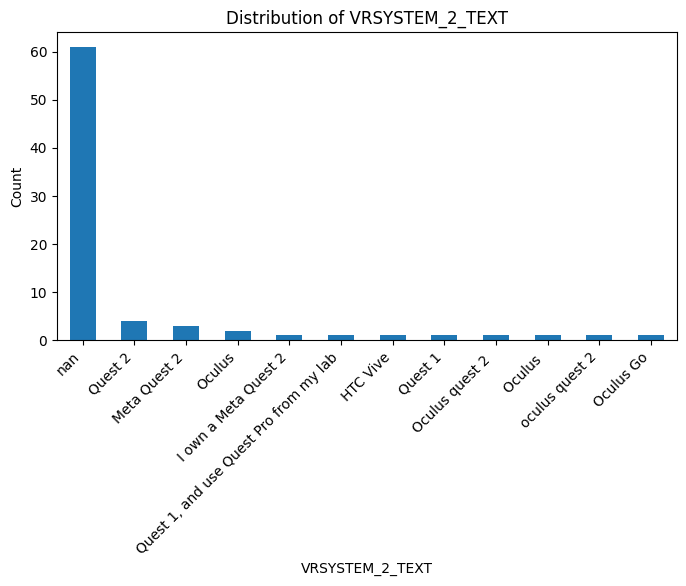

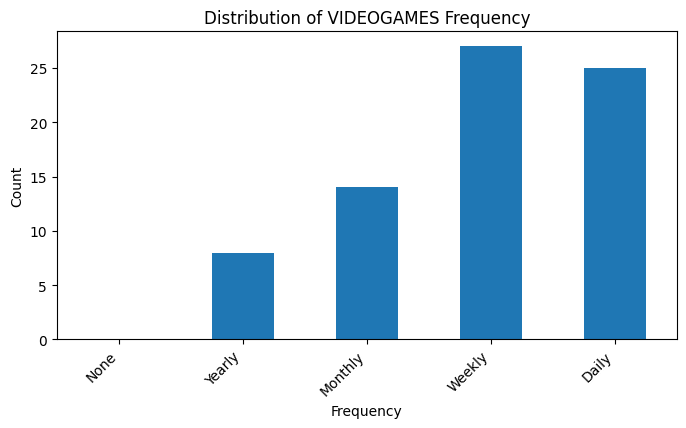

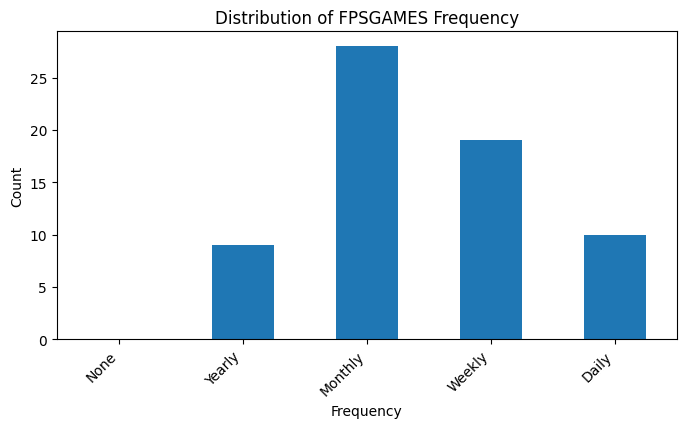

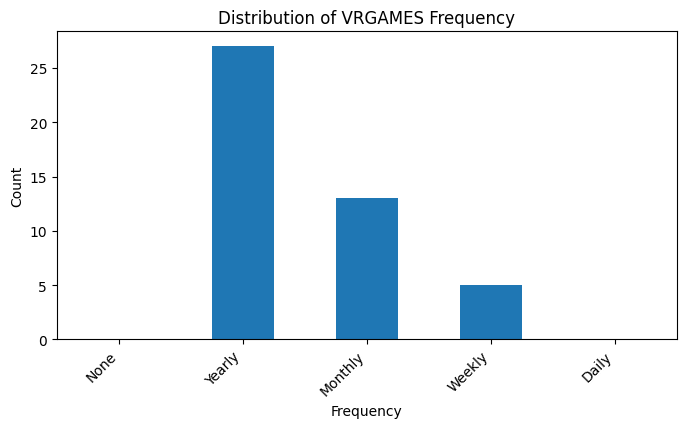

In [14]:
ordinal = ["VIDEOGAMES", "FPSGAMES", "VRGAMES"]
nominal = ["GENDER", "HAND", "LANGUAGE","VRSYSTEM" ,"VRSYSTEM_2_TEXT"]
order =   ["Daily", "Weekly", "Monthly", "Yearly", None][::-1]

for i, col in enumerate(nominal + ordinal):
    
    plt.figure(figsize=(8,4))
    
    if i >= len(nominal):
        df_lang_condensed[col].value_counts(dropna=False).reindex(order).plot(kind='bar')
        plt.title(f"Distribution of {col} Frequency")
        plt.xlabel("Frequency")
    else:
        df_lang_condensed[col].value_counts(dropna=False).plot(kind='bar')
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
    
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Count")
    plt.show()

In [15]:
df_simplified = df_lang_condensed.copy()
df_simplified.drop("VRSYSTEM_2_TEXT", axis=1, inplace=True, errors='ignore')
if "VRSYSTEM_2_TEXT" in nominal:
    nominal.remove("VRSYSTEM_2_TEXT") 

df_simplified["GENDER"] = df_simplified["GENDER"].replace({"Male": "M", "Female": "F"})
df_simplified["HAND"] = df_simplified["HAND"].str.replace(pat=r" hand", repl="", regex=True).str.strip()
df_simplified["VRSYSTEM"] = df_simplified["VRSYSTEM"].str.replace(pat=r" (please specify):", repl="").str.strip()
df_simplified

,GENDER,AGE,HEIGHT_INCHES,WEIGHT_LBS,HAND,LANGUAGE,ETHNICITY,VIDEOGAMES,FPSGAMES,VRGAMES,VRSYSTEM
PID,,,,,,,,,,,
SAME10845F,F,18,68,110,Right,English,White,Monthly,Monthly,NaN,No
SAME12079M,M,22,70,155,Right,English,White,Weekly,Monthly,Yearly,No
SAME13296F,F,19,59,107,Right,Spanish,"Hispanic, Latino, or Spanish",Monthly,Monthly,Yearly,No
SAME14450M,M,25,64,135,Right,English,East/Southeast Asian,Daily,Monthly,Weekly,Yes
SAME15874M,M,19,74,185,Left,English,White,Weekly,Weekly,Monthly,Yes
...,...,...,...,...,...,...,...,...,...,...,...
SAME95887M,M,24,70,140,Right,English,Black or African American,Daily,Monthly,NaN,No
SAME96128F,F,26,63,150,Right,English,East/Southeast Asian,Daily,Monthly,Monthly,Yes
SAME99214M,M,22,66,250,Right,English,White,Weekly,Monthly,NaN,No


In [16]:
df_simplified["LANGUAGE"].value_counts()

LANGUAGE
English           63
Spanish            7
Vietnamese         2
French/spanish     1
Burmese            1
Korean             1
Cantonese          1
Russian            1
Haitian creole     1
Name: count, dtype: int64

# Merging the Motion Data

In [ ]:
import os
import re


def aggregate_df(file):
    groupcol = "TimeElapsed"
    df = pd.read_csv(file).drop("Timestamp", axis=1, errors='ignore')
    aggs = dict.fromkeys(df.columns, ["mean", "median", "std", "min", "max"])
    aggs["Task"] = "first"
    
    grouped = df.groupby(df[groupcol]//1).agg(aggs).drop(groupcol, axis=1, errors='ignore').reset_index()
    grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
    grouped.rename(columns={groupcol+'_':"time_interval", "Task_first": "TASK"}, inplace=True)
    
    return grouped

def read_motion_data():
    
    for i, (rt, dirs, files) in enumerate(os.walk("./Motion")):
        for file in files:
            if not (path := os.path.join(rt, file)).endswith(".csv"):
                continue
            

            pid = os.path.split(rt)[-1]
            type = re.split(r"_(\w)_", file)[1]

            df = aggregate_df(path)
            df["PID"] = pid
            df["TYPE"] = type
            df['FILE'] = path
            
            yield df
            


/var/folders/n3/kkhdszw97tl8hc30cbvg04140000gn/T/ipykernel_44890/3785575031.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  motion_df = pd.concat(motion_data, axis=0)


In [ ]:

# Read and combine motion data 
file = "combined_motion_data.csv"
if os.path.exists(file):
    motion_data = pd.read_csv(file)
else:
    motion_data = read_motion_data()
    motion_data = pd.concat(motion_data, axis=0)
    motion_data.to_csv("combined_motion_data.csv", index=False)

In [91]:
combined_df = df_simplified.merge(motion_data, on="PID", how="inner")
combined_df

,PID,GENDER,AGE,HEIGHT_INCHES,WEIGHT_LBS,HAND,LANGUAGE,ETHNICITY,VIDEOGAMES,FPSGAMES,...,Hips_sixD_e_min,Hips_sixD_e_max,Hips_sixD_f_mean,Hips_sixD_f_median,Hips_sixD_f_std,Hips_sixD_f_min,Hips_sixD_f_max,TASK,TYPE,FILE
0,SAME10845F,F,18,68,110,Right,English,White,Monthly,Monthly,...,0.9914,0.9933,0.111799,0.11275,0.004831,0.1014,0.1184,1,N,./Motion/SAME10845F/Motion_SAME10845F_N_133397...
1,SAME10845F,F,18,68,110,Right,English,White,Monthly,Monthly,...,0.9920,0.9975,0.083418,0.10070,0.026346,0.0353,0.1129,1,N,./Motion/SAME10845F/Motion_SAME10845F_N_133397...
2,SAME10845F,F,18,68,110,Right,English,White,Monthly,Monthly,...,0.9972,0.9995,0.032830,0.03045,0.010461,0.0156,0.0515,1,N,./Motion/SAME10845F/Motion_SAME10845F_N_133397...
3,SAME10845F,F,18,68,110,Right,English,White,Monthly,Monthly,...,0.9946,0.9970,0.065610,0.06815,0.009233,0.0440,0.0790,1,N,./Motion/SAME10845F/Motion_SAME10845F_N_133397...
4,SAME10845F,F,18,68,110,Right,English,White,Monthly,Monthly,...,0.9927,0.9951,0.084980,0.08485,0.007758,0.0738,0.0982,1,N,./Motion/SAME10845F/Motion_SAME10845F_N_133397...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54067,SAME99866F,F,27,61,160,Right,Vietnamese,East/Southeast Asian,NaN,NaN,...,0.9403,0.9480,-0.296463,-0.29680,0.006519,-0.3088,-0.2846,33,G,./Motion/SAME99866F/Motion_SAME99866F_G_133510...
54068,SAME99866F,F,27,61,160,Right,Vietnamese,East/Southeast Asian,NaN,NaN,...,0.9347,0.9406,-0.315367,-0.31415,0.004734,-0.3241,-0.3072,34,G,./Motion/SAME99866F/Motion_SAME99866F_G_133510...
54069,SAME99866F,F,27,61,160,Right,Vietnamese,East/Southeast Asian,NaN,NaN,...,0.9361,0.9485,-0.306049,-0.30725,0.010988,-0.3184,-0.2783,34,G,./Motion/SAME99866F/Motion_SAME99866F_G_133510...
54070,SAME99866F,F,27,61,160,Right,Vietnamese,East/Southeast Asian,NaN,NaN,...,0.9384,0.9450,-0.303857,-0.30475,0.004520,-0.3106,-0.2887,34,G,./Motion/SAME99866F/Motion_SAME99866F_G_133510...


# Modeling
- KNN model with 5 neighbors
- GBM model with 100 estimators
- RF model with 100 estimators

Original code from research

https://github.com/AlphauroraE/Cross-Domain_Gender_Identification_ML_Codebase/blob/main/ml_codebase.py

In [37]:
nominal, ordinal

(['GENDER', 'HAND', 'LANGUAGE', 'VRSYSTEM'],
 ['VIDEOGAMES', 'FPSGAMES', 'VRGAMES'])

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer


label_encoder = LabelEncoder()
target = "ETHNICITY"
X = combined_df.drop([target], axis=1, errors='ignore')
ethnicity = combined_df[target]
ethnicity = label_encoder.fit_transform(ethnicity)





ordinal_transform = ColumnTransformer(
    transformers=[
        ("oneHotEncode", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="if_binary"), nominal+["Type"]),
        ("ordinalEncode", OrdinalEncoder(categories=[order]*len(ordinal), 
                                         handle_unknown="use_encoded_value",
                                         unknown_value=-1), ordinal),
    ], remainder="passthrough", verbose=2)

# Encode ordinal categorical variables
# df_label_encoded = df_simplified.copy()
# df_label_encoded[ordinal] = ordinal_transform.fit_transform(df_label_encoded[ordinal])

ordinal_transform.fit_transform(combined_df)


[ColumnTransformer] .. (1 of 3) Processing oneHotEncode, total=   0.3s
[ColumnTransformer] . (2 of 3) Processing ordinalEncode, total=   0.2s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


array([[0.0, 1.0, 0.0, ..., 0.1014, 0.1184, 1],
       [0.0, 1.0, 0.0, ..., 0.0353, 0.1129, 1],
       [0.0, 1.0, 0.0, ..., 0.0156, 0.0515, 1],
       ...,
       [0.0, 1.0, 0.0, ..., -0.3184, -0.2783, 34],
       [0.0, 1.0, 0.0, ..., -0.3106, -0.2887, 34],
       [0.0, 1.0, 0.0, ..., -0.3016, -0.3008, 34]],
      shape=(54072, 416), dtype=object)

In [46]:
label_encoder.inverse_transform(ethnicity)

array([3, 3, 3, ..., 1, 1, 1], shape=(54072,))